# Plot motion energy

In [1]:
import numpy as np
from one.api import ONE
import pandas as pd
import matplotlib.pyplot as plt
from brainbox.processing import bincount2D
from scipy.interpolate import interp1d
from scipy.stats import zscore
import pickle
import seaborn as sns
import os

#Generate scatterplots, variances, 2-state AR-HMMs to summarize differences in behavior in different sessions. Develop a 1-page figure per session that provides a behavioral overview.  Would be great to generate these figs for the RS sessions noted in repro-ephys slides above
#lickogram
# https://github.com/lindermanlab/ssm

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import downsample, get_ME, find_nearest
from one_functions_generic import subjects_interest_data, prepro, timeseries_PSTH

In [2]:
one = ONE()

In [3]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))
#example_session = 'cb2ad999-a6cb-42ff-bf71-1774c57e5308'

### Custom

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


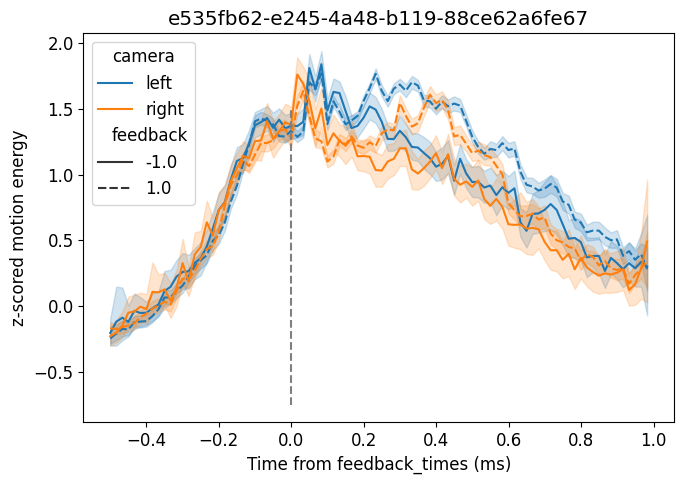

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


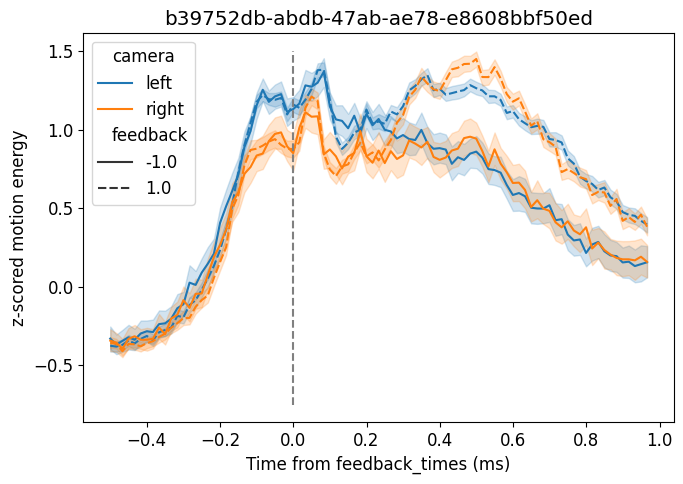

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


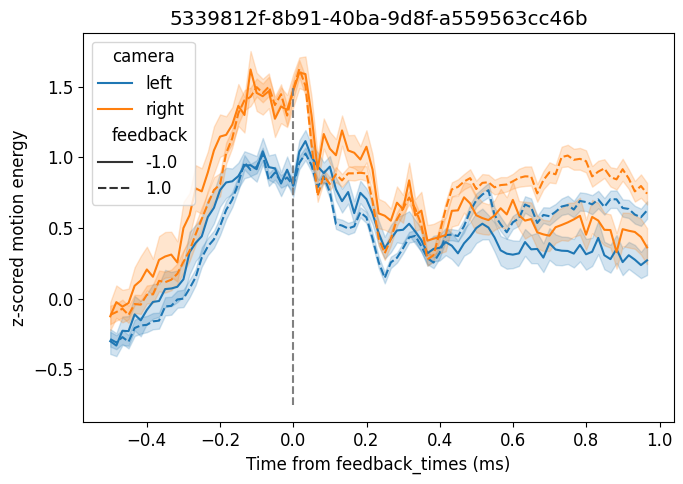

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


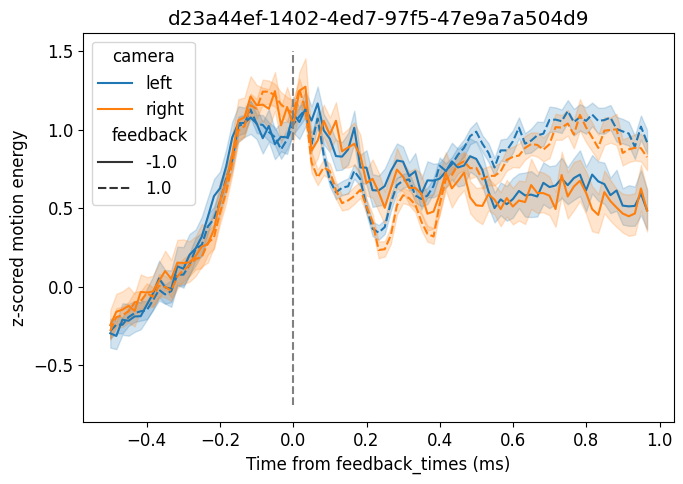

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


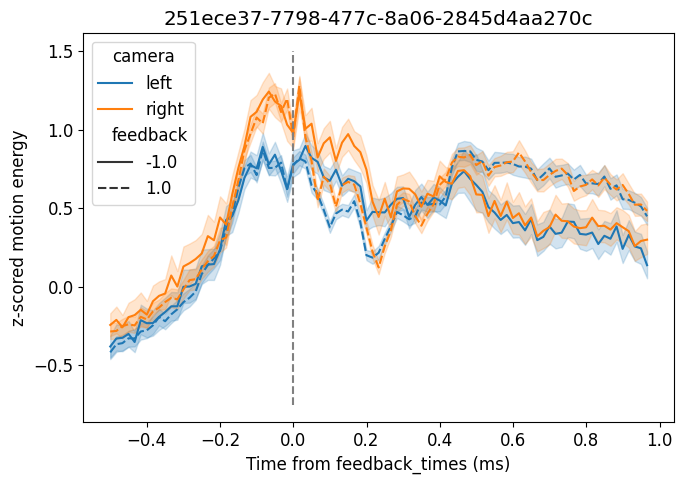

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


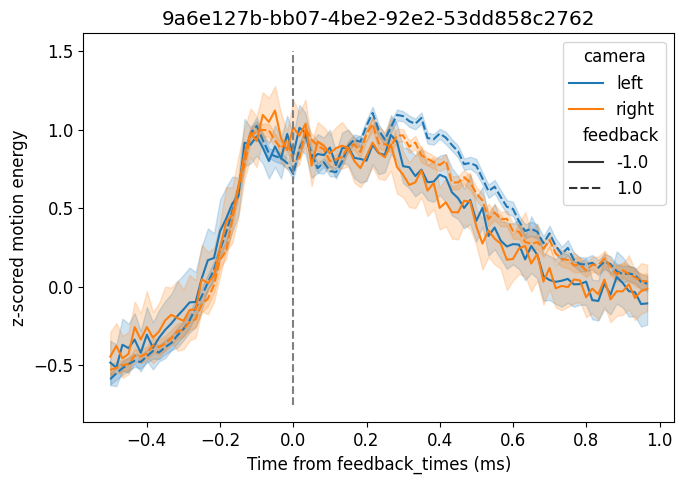

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


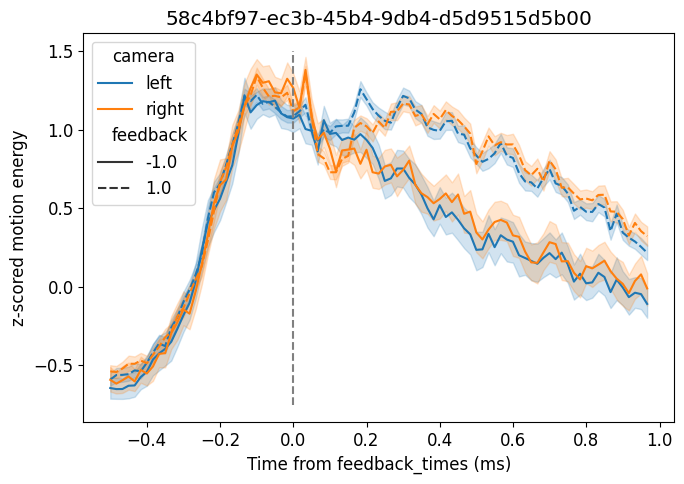

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


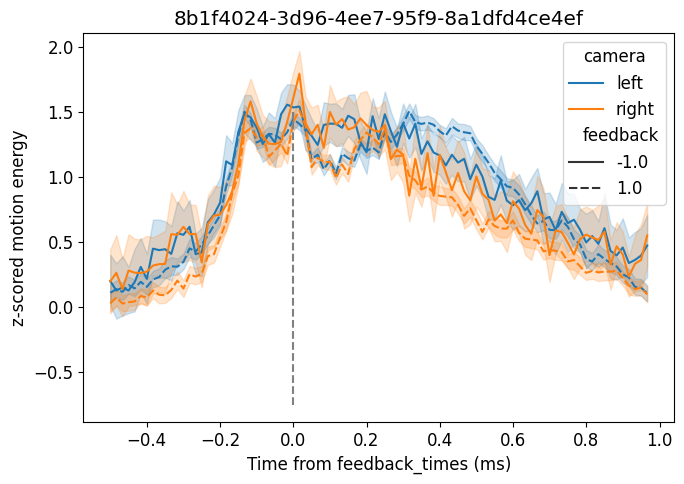

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


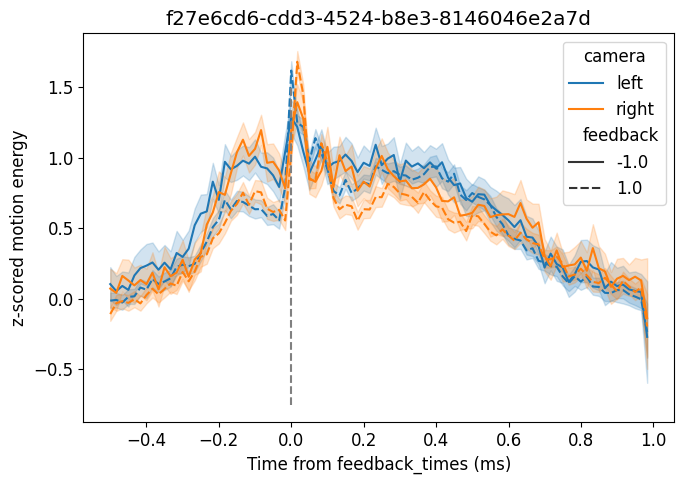

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


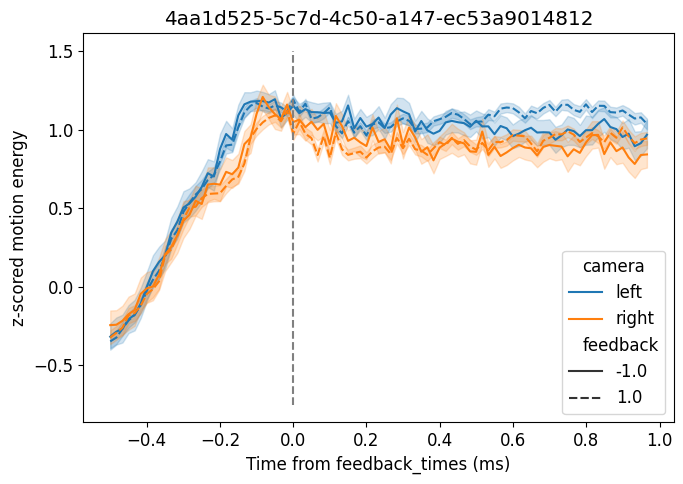

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


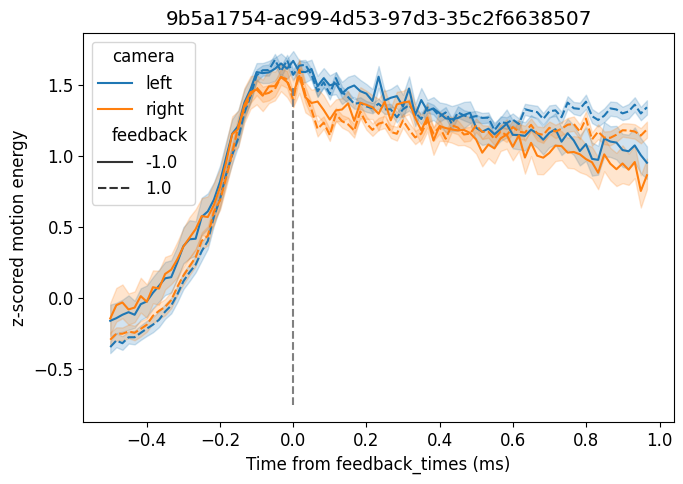

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


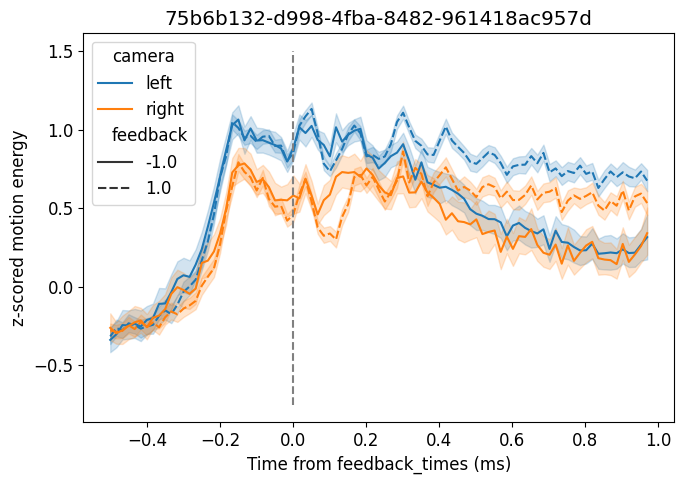

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


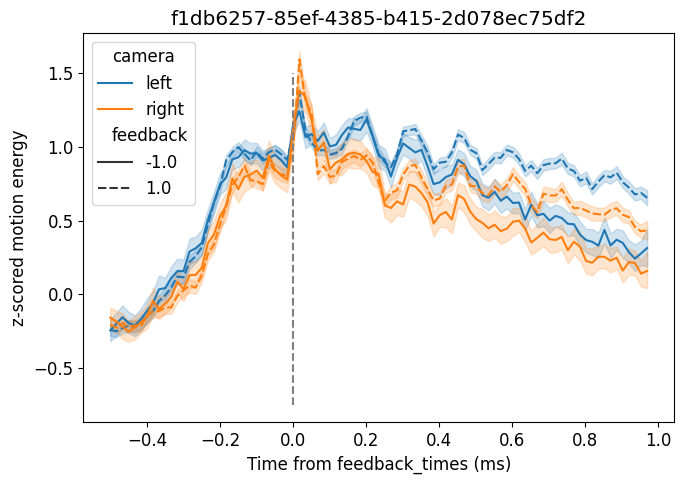

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


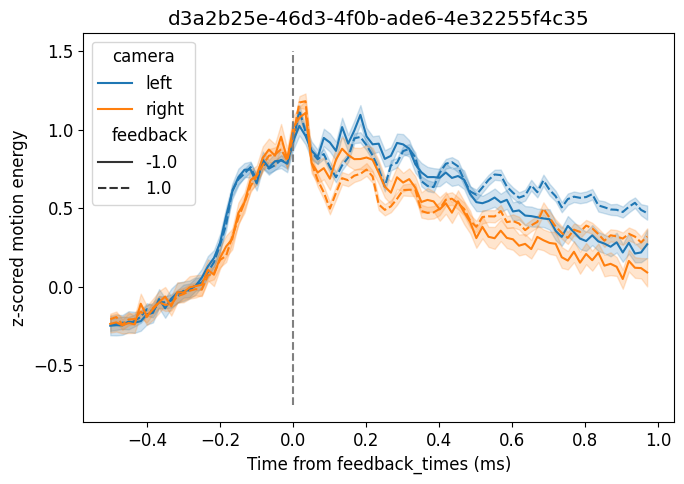

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


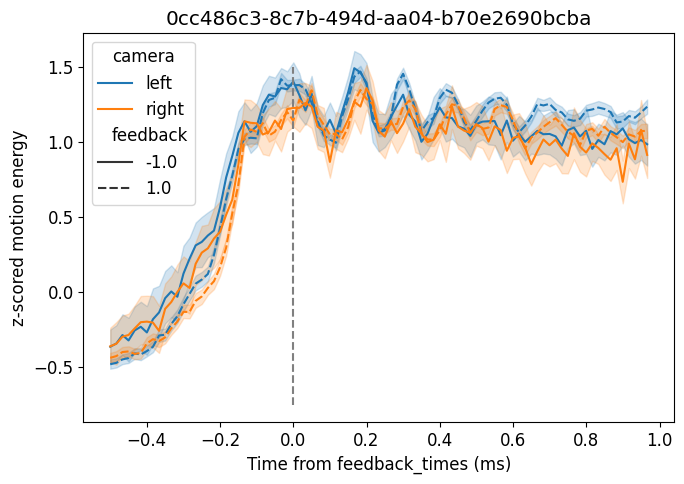

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


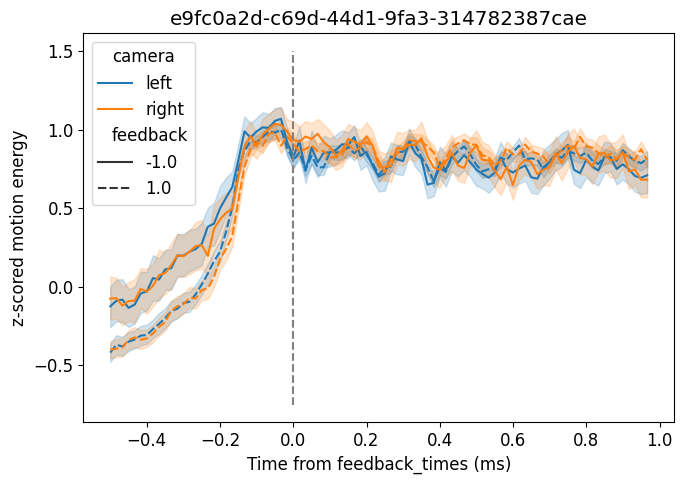

/tmp/ipykernel_7923/1281443119.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ME_joint = ME_left.append(ME_right)


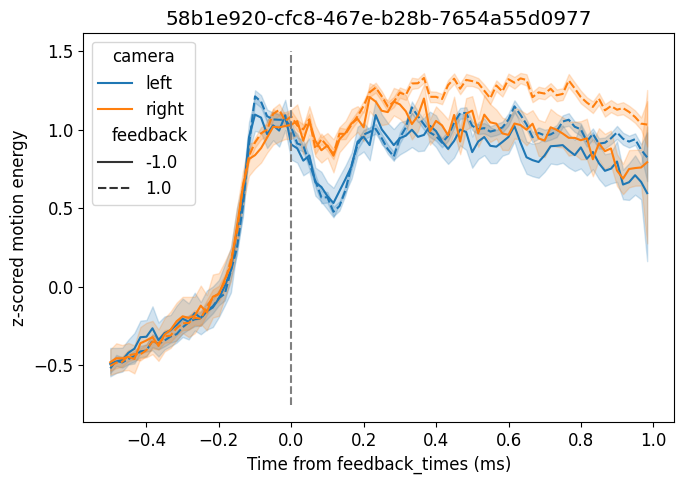

In [89]:
t_init = 0.5
t_end = 1
event = 'stimOn_times'
event = 'feedback_times'
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/'

for s, session in enumerate(list(pass_qc)[8:]):
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df() 
    
    ME = {}

    ts = session_trials.intervals_0[0]
    te = list(session_trials.intervals_1)[-1]

    for video_type in ['left','right']:
        t,m = get_ME(session, video_type)       
        m = zscore(m,nan_policy='omit') 

        sta, end = find_nearest(t,ts), find_nearest(t,te) 
        t = t[sta:end]
        m = m[sta:end]
        
        ME[video_type] = [t,m]

    
    # Downsample right camera
    to_shorten = ['right']
    reference = 'left'
    for video_type in to_shorten:

        # align time series camera/neural
        interpolater = interp1d(
            ME[video_type ][0],
            np.arange(len(ME[video_type ][0])),
            kind="cubic",
            fill_value="extrapolate")

        idx_aligned = np.round(interpolater(ME[reference][0])).astype(int)
        ME[video_type] = [ME[reference][0], ME[video_type][1][idx_aligned]]

    # Align data for PSTH
    ME_left = timeseries_PSTH(ME['left'][0], ME['left'][1], session_trials, event, t_init, t_end, subtract_baseline=False)
    ME_right = timeseries_PSTH(ME['right'][0], ME['right'][1], session_trials, event, t_init, t_end, subtract_baseline=False)

    ME_left['camera'] = 'left'
    ME_right['camera'] = 'right'
    
    ME_joint = ME_left.append(ME_right)
    
    # Plot and save
    cameras = ['left', 'right']
    #data = [ME_left, ME_right]

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=[7, 5])

    plt.rc('font', size=12)

    this_data = ME_joint.reset_index()
    this_data['smooth_value'] = this_data['value'].rolling(3, min_periods=1).mean()
    this_data = this_data.loc[this_data['choice'].isin([1., -1.])]
    sns.lineplot(x='variable', y='smooth_value', style='feedback', hue='camera', data=this_data, ax = ax)
    #plt.hlines(0, -0.5, 1, color='gray', linestyles='--')
    plt.vlines(0, -.75, 1.5, color='gray', linestyles='--')
    ax.set_xlabel(' ')
    ax.set_xlabel('Time from ' + event + ' (ms)')
    ax.set_ylabel('z-scored motion energy')
    ax.set_ylabel('z-scored motion energy')
    ax.set_title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

### Overview plot

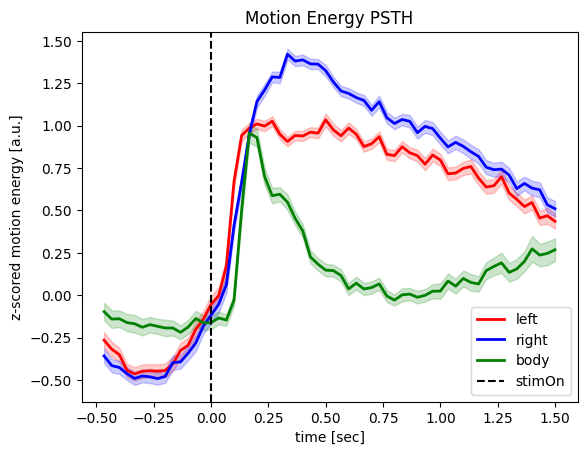

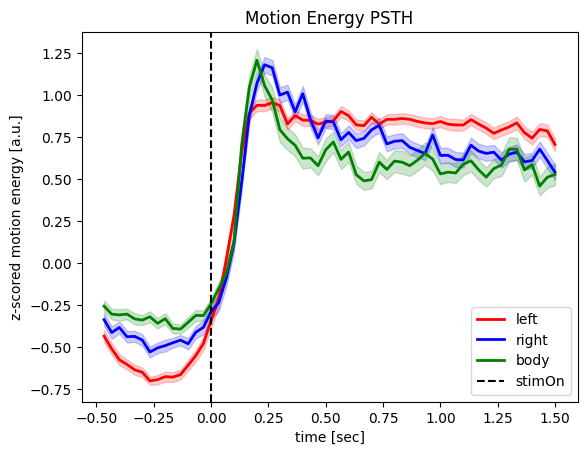

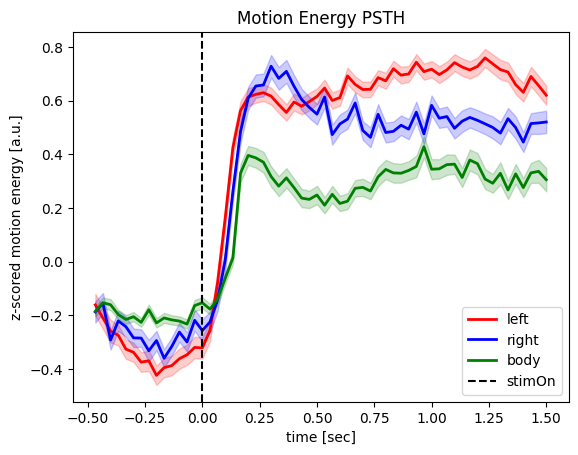

local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/leftCamera.ROIMotionEnergy.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.07M/2.07M [00:02<00:00, 894kB/s] 
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/rightCamera.ROIMotionEnergy.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.17M/5.17M [00:02<00:00, 2.47MB/s]
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/bodyCamera.ROIMotionEnergy.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.04M/1.04M [00:01<00:00, 907kB/s]


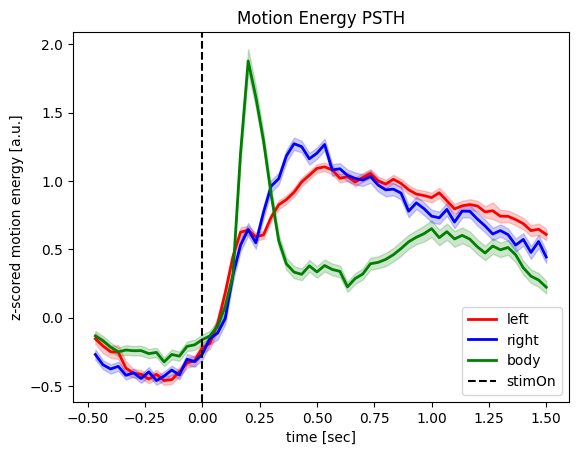

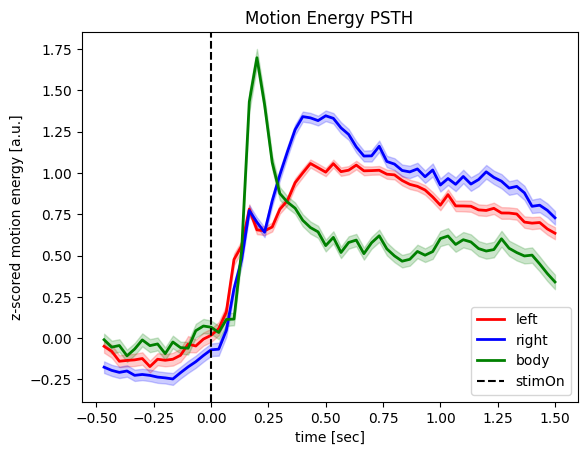

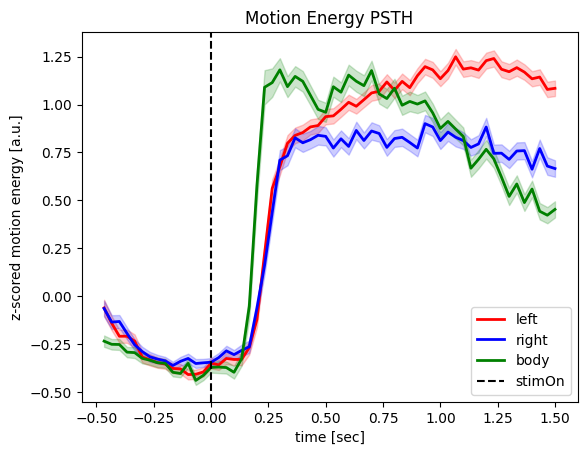

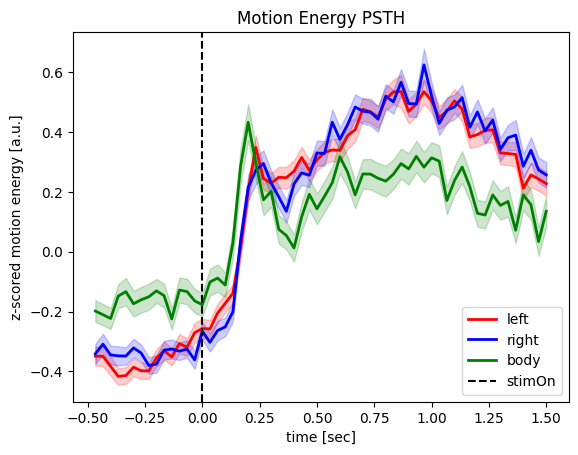

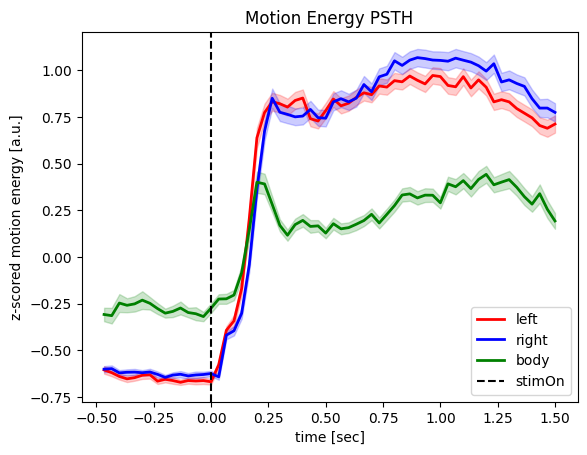

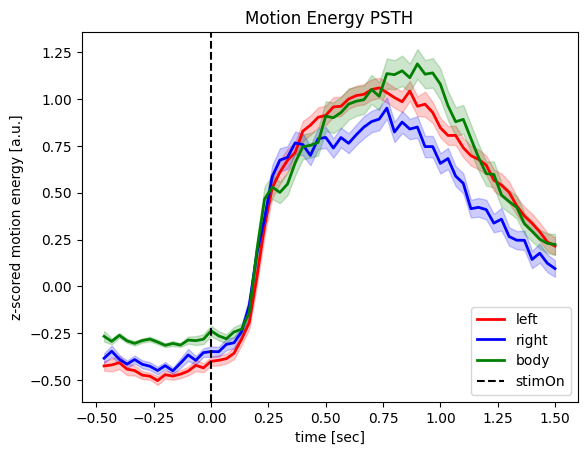

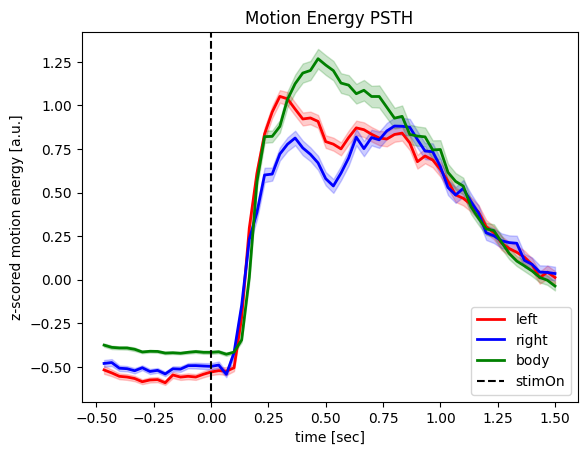

In [11]:
t_init = 0.5
t_end = 1
event = 'stimOn_times'
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/'

for s, session in enumerate(list(pass_qc)[:10]):
    
    motion_energy_PSTH(session)

In [7]:
ME = get_ME('58b1e920-cfc8-467e-b28b-7654a55d0977', 'left')

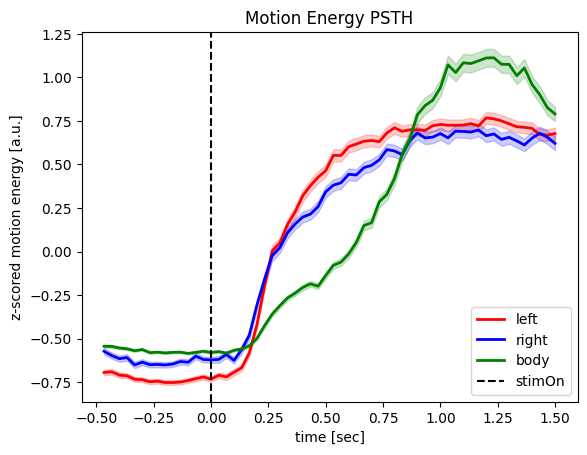

In [26]:
eid = '15f742e1-1043-45c9-9504-f1e8a53c1744'
eid = 'cb2ad999-a6cb-42ff-bf71-1774c57e5308'
motion_energy_PSTH(eid)

In [94]:
eid = 'cb2ad999-a6cb-42ff-bf71-1774c57e5308'
alf_path = one.eid2path(eid)
video_type = 'right'
# Download a single video
video_path = (alf_path / 
    f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4')

if not os.path.isfile(video_path):
    print('mp4 not found locally, downloading it ...')
    video_path = one.load_dataset(eid,
        f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4',
        download_only=True)

In [92]:
video_path

PosixPath('/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZM_2245/2020-01-21/002/raw_video_data/_iblrig_rightCamera.raw.mp4')

In [101]:
"""
For a session where there is DLC already computed,
load DLC traces to cut video ROIs and then
compute motion energy for these ROIS.

bodyCamera: cut ROI such that mouse body but not wheel motion is in ROI

left(right)Camera: cut whisker pad region
"""

import time
import numpy as np
import pandas as pd
import cv2
import logging

from ibllib.io.video import get_video_frames_preload, label_from_path
from ibllib.io.extractors.camera import get_video_length

_log = logging.getLogger('ibllib')


def grayscale(x):
    return cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)


def get_dlc_midpoints(dlc_pqt, target):
    # Load dataframe
    dlc_df = pd.read_parquet(dlc_pqt)
    # Set values to nan if likelihood is too low and calcualte midpoints
    idx = dlc_df.loc[dlc_df[f'{target}_likelihood'] < 0.9].index
    dlc_df.loc[idx, [f'{target}_x', f'{target}_y']] = np.nan
    if all(np.isnan(dlc_df[f'{target}_x'])) or all(np.isnan(dlc_df[f'{target}_y'])):
        raise ValueError(f'Failed to calculate midpoint, {target} all NaN in {dlc_pqt}')
    else:
        mloc = [int(np.nanmean(dlc_df[f'{target}_x'])), int(np.nanmean(dlc_df[f'{target}_y']))]
        return mloc


def motion_energy(file_mp4, dlc_pqt, frames=10000):
    """
    Compute motion energy on cropped frames of a single video

    :param file_mp4: Video file to run motion energy for
    :param dlc_pqt: Path to dlc result in pqt file format.
    :param frames: Number of frames to load into memory at once. If None all frames are loaded.
    :return me_file: Path to numpy file contaiing motion energy.
    :return me_roi: Path to numpy file containing ROI coordinates.

    The frames parameter determines how many cropped frames per camera are loaded into memory at
    once and should be set depending on availble RAM. Some approximate numbers for orientation,
    assuming 90 min video and frames set to:
    1       : 152 KB (body),   54 KB (left),   15 KB (right)
    50000   : 7.6 GB (body),  2.7 GB (left), 0.75 GB (right)
    None    :  25 GB (body), 17.5 GB (left), 12.5 GB (right)
    """

    start_T = time.time()
    label = label_from_path(dlc_pqt)

    # Crop ROI
    if label == 'body':
        tail_mid = get_dlc_midpoints(dlc_pqt, 'tail_start')
        anchor = np.array(tail_mid)
        w, h = int(anchor[0] * 3 / 5), 210
        x, y = int(anchor[0] - anchor[0] * 3 / 5), int(anchor[1] - 120)
    else:
        nose_mid = get_dlc_midpoints(dlc_pqt, 'nose_tip')
        # Go through the different pupil points to see if any has not all NaNs
        try:
            pupil_mid = get_dlc_midpoints(dlc_pqt, 'pupil_top_r')
        except ValueError:
            try:
                pupil_mid = get_dlc_midpoints(dlc_pqt, 'pupil_left_r')
            except ValueError:
                try:
                    pupil_mid = get_dlc_midpoints(dlc_pqt, 'pupil_right_r')
                except ValueError:
                    pupil_mid = get_dlc_midpoints(dlc_pqt, 'pupil_bottom_r')
        anchor = np.mean([nose_mid, pupil_mid], axis=0)
        dist = np.sqrt(np.sum((np.array(nose_mid) - np.array(pupil_mid))**2, axis=0))
        w, h = int(dist / 2), int(dist / 3)
        x, y = int(anchor[0] - dist / 4), int(anchor[1])

    # Check if the mask has negative values (sign that the midpoint location is off)
    if any(i < 0 for i in [x, y, w, h]) is True:
        raise ValueError(f"ROI for motion energy on {label}Camera could not be computed. "
                         f"Check for issues with the raw video or dlc output.")

    # Note that x and y are flipped when loading with cv2, therefore:
    mask = np.s_[y:y + h, x:x + w]

    # save ROI coordinates
    roi = np.asarray([w, h, x, y])
    alf_path = file_mp4.parent.parent.joinpath('alf')
    alf_path.mkdir(exist_ok=True)
    roi_file = alf_path.joinpath(f'{label}ROIMotionEnergy.position.npy')
    np.save(roi_file, roi)

    frame_count = get_video_length(file_mp4)
    me = np.zeros(frame_count,)

    cap = cv2.VideoCapture(str(file_mp4))
    if frames:
        n, keep_reading = 0, True
        while keep_reading:
            # Set the frame numbers to the next #frames, with 1 frame overlap
            frame_numbers = range(n * (frames - 1), n * (frames - 1) + frames)
            # Make sure not to load empty frames
            if np.max(frame_numbers) >= frame_count:
                frame_numbers = range(frame_numbers.start, frame_count)
                keep_reading = False
            # Load, crop and grayscale frames.
            cropped_frames = get_video_frames_preload(cap, frame_numbers=frame_numbers,
                                                      mask=mask, func=grayscale,
                                                      quiet=True).astype(np.float32)
            # Calculate motion energy for those frames and append to big array
            me[frame_numbers[:-1]] = np.mean(np.abs(np.diff(cropped_frames, axis=0)), axis=(1, 2))
            # Next set of frames
            n += 1
    else:
        # Compute on entire video at once
        cropped_frames = get_video_frames_preload(cap, frame_numbers=None, mask=mask,
                                                  func=grayscale, quiet=True).astype(np.float32)
        me[:-1] = np.mean(np.abs(np.diff(cropped_frames, axis=0)), axis=(1, 2))

    # copy last value to make motion energy fit frame length
    cap.release()
    me[-1] = me[-2]

    # save ME
    me_file = alf_path.joinpath(f'{label}Camera.ROIMotionEnergy.npy')
    np.save(me_file, me)
    end_T = time.time()
    print(f'{label}Camera computed in', np.round((end_T - start_T), 2))

    return me_file, roi_file

In [98]:
one = ONE()    
eid = '572a95d1-39ca-42e1-8424-5c9ffcb2df87'
eid = 'cb2ad999-a6cb-42ff-bf71-1774c57e5308'
video_type = 'left'

# Download a single video
video_path = (alf_path / 
    f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4')

if not os.path.isfile(video_path):
    print('mp4 not found locally, downloading it ...')
    video_path = one.load_dataset(eid,
        f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4',
        download_only=True)
    
file_mp4 = video_path
dlc_pqt = (alf_path / 
    f'alf/_ibl_{video_type}Camera.dlc.pqt')
#motion_energy(file_mp4, dlc_pqt, frames=10000)

mp4 not found locally, downloading it ...


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZM_2245/2020-01-21/002/raw_video_data/_iblrig_leftCamera.raw.mp4: 100%|██████████| 6.51G/6.51G [06:07<00:00, 17.7MB/s] 
